In [1]:
import cv2
import numpy as np


def resize_frame(frame):
    frame = frame[30:-12,5:-4]
    frame = np.average(frame,axis = 2)
    frame = cv2.resize(frame,(84,84),interpolation = cv2.INTER_NEAREST)
    frame = np.array(frame,dtype = np.uint8)
    return frame

In [2]:
from collections import deque

class Memory():
    def __init__(self,max_len):
        self.max_len = max_len
        self.frames = deque(maxlen = max_len)
        self.actions = deque(maxlen = max_len)
        self.rewards = deque(maxlen = max_len)
        self.done_flags = deque(maxlen = max_len)

    def add_experience(self,next_frame, next_frames_reward, next_action, next_frame_terminal):
        self.frames.append(next_frame)
        self.actions.append(next_action)
        self.rewards.append(next_frames_reward)
        self.done_flags.append(next_frame_terminal)

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt

def initialize_new_game(name, env, agent):
    """We don't want an agents past game influencing its new game, so we add in some dummy data to initialize"""
    
    env.reset()
    starting_frame = resize_frame(env.step(0)[0])

    dummy_action = 0
    dummy_reward = 0
    dummy_done = False
    for i in range(3):
        agent.memory.add_experience(starting_frame, dummy_reward, dummy_action, dummy_done)

def make_env(name, agent, debug):
    if debug:
        env = gym.make(name, render_mode='human')
    else:
        env = gym.make(name)
    return env

def take_step(name, env, agent, score, debug):
    
    # Update timesteps and save weights
    agent.total_timesteps += 1
    if agent.total_timesteps % 5000 == 0:
      agent.model.save_weights('recent_weights.hdf5')
      print('\nWeights saved!')

    # Take action
    next_frame, next_frames_reward, next_frame_terminal, info = env.step(agent.memory.actions[-1])
    
    # Get next state
    next_frame = resize_frame(next_frame)
    new_state = [agent.memory.frames[-3], agent.memory.frames[-2], agent.memory.frames[-1], next_frame]
    new_state = np.moveaxis(new_state,0,2)/255 #We have to do this to get it into keras's goofy format of [batch_size,rows,columns,channels]
    new_state = np.expand_dims(new_state,0) #^^^
    
    # Get next action, using next state
    next_action = agent.get_action(new_state)

    # If game is over, return the score
    if next_frame_terminal:
        agent.memory.add_experience(next_frame, next_frames_reward, next_action, next_frame_terminal)
        return (score + next_frames_reward),True

    # Now we add the next experience to memory
    agent.memory.add_experience(next_frame, next_frames_reward, next_action, next_frame_terminal)

    # If the threshold memory is satisfied, make the agent learn from memory
    if len(agent.memory.frames) > agent.starting_mem_len:
        agent.learn(debug)

    return (score + next_frames_reward),False

def plot_statistics(statistics, y_limits=None, open_window=False):
    x = [statistic['learns'] for statistic in statistics]
    y = [statistic['score'] for statistic in statistics]

    mean = np.mean(y)

    fig, ax = plt.subplots()
    if y_limits:
        ax.set_ylim(y_limits)

    ax.plot(x, y, label="scores")
    ax.plot(x, [mean] * len(x), label=f'mean {mean}')

    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.show(block=open_window)
    plt.close('all')

def play_episode(name, env, agent, debug = False):
    initialize_new_game(name, env, agent)
    done = False
    score = 0
    while True:
        score,done = take_step(name,env,agent,score, debug)
        if done:
            break
    return score

In [4]:
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf
import numpy as np
import random


class Agent():
    def __init__(self,possible_actions,starting_mem_len,max_mem_len,starting_epsilon,learn_rate,epochs, debug = False):
        self.memory = Memory(max_mem_len)
        self.possible_actions = possible_actions
        self.epsilon = starting_epsilon
        self.epsilon_decay = .9/epochs
        self.epsilon_min = .05
        self.gamma = .95
        self.learn_rate = learn_rate
        self.model = self._build_model()
        self.model_target = clone_model(self.model)
        self.total_timesteps = 0
        self.starting_mem_len = starting_mem_len
        self.learns = 0


    def _build_model(self):
        model = Sequential()
        model.add(Input((84,84,4)))
        model.add(Conv2D(filters = 32,kernel_size = (8,8),strides = 4,data_format="channels_last", activation = 'relu',kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Conv2D(filters = 64,kernel_size = (4,4),strides = 2,data_format="channels_last", activation = 'relu',kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Conv2D(filters = 64,kernel_size = (3,3),strides = 1,data_format="channels_last", activation = 'relu',kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Flatten())
        model.add(Dense(512,activation = 'relu', kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Dense(len(self.possible_actions), activation = 'linear'))
        optimizer = Adam(self.learn_rate)
        model.compile(optimizer, loss=tf.keras.losses.Huber())
        return model

    def get_action(self,state):
        """Explore"""
        if np.random.rand() < self.epsilon:
            return random.sample(self.possible_actions,1)[0]

        """Do Best Acton"""
        a_index = np.argmax(self.model.predict(state))
        return self.possible_actions[a_index]

    def _index_valid(self,index):
        if self.memory.done_flags[index-3] or self.memory.done_flags[index-2] or self.memory.done_flags[index-1] or self.memory.done_flags[index]:
            return False
        else:
            return True

    def learn(self,debug = False):
        """we want the output[a] to be R_(t+1) + Qmax_(t+1)."""
        """So target for taking action 1 should be [output[0], R_(t+1) + Qmax_(t+1), output[2]]"""

        """First we need 32 random valid indicies"""
        states = []
        next_states = []
        actions_taken = []
        next_rewards = []
        next_done_flags = []

        while len(states) < 32:
            index = np.random.randint(4,len(self.memory.frames) - 1)
            if self._index_valid(index):
                state = [self.memory.frames[index-3], self.memory.frames[index-2], self.memory.frames[index-1], self.memory.frames[index]]
                state = np.moveaxis(state,0,2)/255
                next_state = [self.memory.frames[index-2], self.memory.frames[index-1], self.memory.frames[index], self.memory.frames[index+1]]
                next_state = np.moveaxis(next_state,0,2)/255

                states.append(state)
                next_states.append(next_state)
                actions_taken.append(self.memory.actions[index])
                next_rewards.append(self.memory.rewards[index+1])
                next_done_flags.append(self.memory.done_flags[index+1])

        """Now we get the ouputs from our model, and the target model. We need this for our target in the error function"""
        labels = self.model.predict(np.array(states))
        next_state_values = self.model_target.predict(np.array(next_states))
        
        """Now we define our labels, or what the output should have been
           We want the output[action_taken] to be R_(t+1) + Qmax_(t+1) """
        for i in range(32):
            action = self.possible_actions.index(actions_taken[i])
            labels[i][action] = next_rewards[i] + (1 - next_done_flags[i]) * self.gamma * max(next_state_values[i])

        """Train our model using the states and outputs generated"""
        self.model.fit(np.array(states),labels,batch_size = 32, epochs = 1, verbose = 0)

        """Decrease epsilon and update how many times our agent has learned"""
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay
        self.learns += 1
        
        """Every 1000 learned, copy our model weights to our target model"""
        if self.learns % 1000 == 0:
            self.model_target.set_weights(self.model.get_weights())
            print('\nTarget model updated')

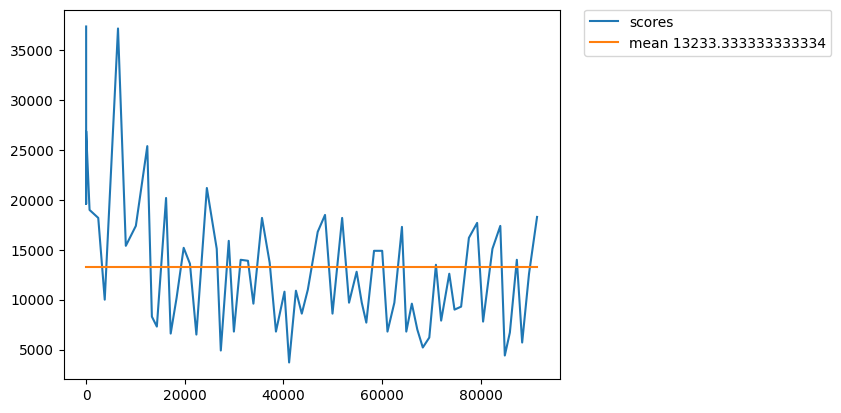

 69%|██████▉   | 69/100 [34:01:25<43:17:01, 5026.50s/it]

1/1 [==============================] - 1s 569ms/step


In [5]:
import time
from collections import deque
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output

epochs = 100
name = 'Atlantis-v0'
debug = False
agent = Agent(possible_actions=[0,1,2,3],starting_mem_len=10000,max_mem_len=750000,starting_epsilon = 1,epochs=epochs, learn_rate = .00025)
env = make_env(name,agent,debug)

""" If testing:
agent.model.load_weights('recent_weights.hdf5')
agent.model_target.load_weights('recent_weights.hdf5')
agent.epsilon = 0.0
"""

env.reset()
statistics = []
for i in tqdm(range(epochs)):
    start = time.time()
    score = play_episode(name, env, agent, debug = debug) #set debug to true for rendering
    end = time.time()
    statistics.append({"episode":i,"score":score,"time":end-start,"learns":agent.learns})
    clear_output()
    plot_statistics(statistics)